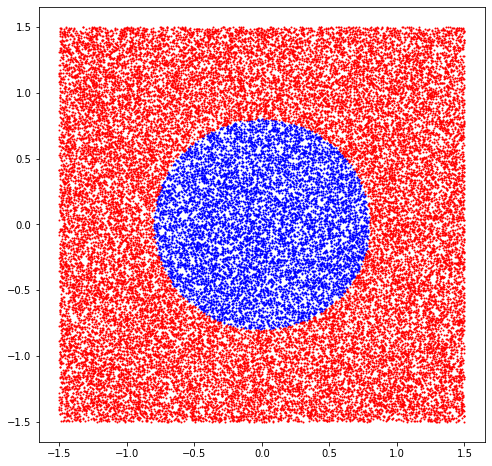

In [75]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.callbacks import TensorBoard
%matplotlib inline

N=40000
K=3
X = K*np.random.rand(N,2) 
X[:,0] = X[:,0]-K/2
X[:,1] = X[:,1]-K/2

Y = np.zeros([N,2])

for i in range(N):
    if (X[i,0])**2+(X[i,1])**2<0.64:
        Y[i,0]=1
    else:
        Y[i,1]=1

zero_class = np.where(Y[:, 0])
one_class = np.where(Y[:, 1])

plt.figure(figsize=(8, 8))
plt.scatter(X[zero_class, 0], X[zero_class, 1], s=1, facecolors='b', linewidths=1, label='Class 1')
plt.scatter(X[one_class, 0], X[one_class, 1], s=1, facecolors='r', linewidths=1, label='Class 2')
plt.show()

data = X
labels = Y

In [132]:
hid_layer_units = [3, 3]
style = ['intensity_plot','color_plot']
plot_style = style[1]

model = tf.keras.Sequential()
for i in range(len(hid_layer_units)):
    if i == 0:
        model.add(Dense(hid_layer_units[i], input_shape=(2,), activation='relu',bias_initializer='random_uniform'))
    else:
        model.add(Dense(hid_layer_units[i], activation='relu',bias_initializer='random_uniform'))
model.add(Dense(2, activation='softmax',bias_initializer='random_uniform'))

# Configure a model for categorical classification.
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.categorical_accuracy])

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

model_name = '_'.join(str(e) for e in hid_layer_units)+'_2'+'_'+plot_style

import os
directory = 'iterasive_result/'+'model_'+model_name
if not os.path.exists(directory):
    os.makedirs(directory)
    
model.save(directory+'/'+model_name+'_model.h5') 

In [133]:
# for i in range(100):
#     step = i+1
#     model.fit(data, labels, epochs=1,steps_per_epoch=step,batch_size=int(N/800),callbacks=[tensorboard])

In [134]:
from tensorflow.keras import backend as K
#define function list to get each layer output
get_layer_output_functions = []
for i in range(len(model.layers)):
    get_layer_output_functions.append(K.function(model.layers[0].input,model.layers[i].output))

#function to get activation of input data into a list
def get_activation(data): 
    layer_output = []
    for f in get_layer_output_functions:
        layer_output.append(f(data.reshape(1,2))[0])

    for i in range(len(layer_output)):
        #layer_nonzero_index = np.flatnonzero(layer_output[i])
        layer_output[i][np.flatnonzero(layer_output[i])] = 1
        layer_output[i] = layer_output[i].astype(int)
        
    act_list = layer_output
    return act_list

#assign a different color to each different activation,use color index
def assign_color(activations,act_index):
    color_index = 0
    for i in range(len(hid_layer_units)):
        binary = ''.join(str(e) for e in activations[act_index][i].astype(int))
        color_index+=int(binary,2)
    return color_index

interval = int(np.ceil(255/2**(np.sum(hid_layer_units)/3.0)))
R = range(0,255,interval)
G = range(0,255,interval)
B = range(0,255,interval)
rv,gv,bv = np.meshgrid(R,G,B)
colors = np.array([rv.flatten(),gv.flatten(),bv.flatten()]).transpose()
np.random.shuffle(colors)

In [ ]:
import multiprocessing
from multiprocessing import Pool
from functools import partial

Grid = 200
k = 2
x = np.linspace(-k,k,Grid+1)
y = np.linspace(-k,k,Grid+1) 

xv,yv = np.meshgrid( x , y )
X_test = np.array([xv.flatten(),yv.flatten()])
X_test = X_test.transpose()
 
num_epoch = 100
pool = Pool(10)
for i in range(num_epoch):
    print("epoch:{0}".format(i), end="\n")
    #loop for all data points to get activations
    i_data = 0
    activations = []

    for test_data in X_test:
        print("get activation progress:{0}%".format(round((i_data + 1) * 100 / len(X_test))), end='\r')
        activations.append(get_activation(test_data))
        i_data = i_data + 1
    print(end="\n")
    
    f = partial(assign_color,activations)
    
    i_color=0
    data_activation_color=[]
    for y in pool.map(f, range(len(activations))):
        i_color+=1
        print("get data color progress:{0}%".format(round((i_color + 1) * 100 / len(activations))), end="\r")
        data_activation_color.append(y)
    print(end="\n")
    
    data_activation_color = np.asarray(data_activation_color)
    if plot_style == style[1]:
        data_activation_color = colors[data_activation_color]/255
#     data_activation_color = colors[]
#     act_clusters = np.unique(data_activation_color)
#     cluster_index = []
#     for j in range(len(act_clusters)):
#         cluster_index.append(np.where(data_activation_color == act_clusters[j]))

    plt.figure(figsize=(8, 8))
    plt.scatter(X_test[:, 0], X_test[:, 1], marker='o',s=4, c=data_activation_color, linewidths=2,cmap = 'gray')
    plt.savefig(directory+'/'+'epoch'+str(format(i,'0>3'))+'_'+model_name+'_activation')
    plt.close()
    
    Y_test = model.predict(X_test)
    Y_test = np.rint(Y_test)
    zero_class_test = np.where(Y_test[:, 0])
    one_class_test = np.where(Y_test[:, 1])

    plt.figure(figsize=(8, 8))
    plt.scatter(X_test[zero_class_test, 0], X_test[zero_class_test, 1], marker='o',s=3, facecolors='r', linewidths=1, label='Class 1')
    plt.scatter(X_test[one_class_test, 0], X_test[one_class_test, 1], marker='o', s=1, facecolors='b', linewidths=1, label='Class 2')
    plt.savefig(directory+'/'+'epoch'+str(format(i,'0>3'))+'_'+model_name+'_decisionboundary')    
    plt.close()
    
    step = i+1
    model.fit(data, labels, epochs=1,steps_per_epoch=step,batch_size=int(N/800),callbacks=[tensorboard])
    
pool.close()
pool.join()

epoch:0
get activation progress:100%
get data color progress:100%
Train on 1 samples
1/1 [==============================] - 0s 159ms/step - loss: 0.8082 - categorical_accuracy: 0.2241
epoch:1
get activation progress:100%
get data color progress:100%
Train on 2 samples
2/2 [==============================] - 0s 31ms/step - loss: 0.8053 - categorical_accuracy: 0.2241
epoch:2
get activation progress:100%
get data color progress:100%
Train on 3 samples
3/3 [==============================] - 0s 28ms/step - loss: 0.8006 - categorical_accuracy: 0.2241
epoch:3
get activation progress:100%
get data color progress:100%
Train on 4 samples
4/4 [==============================] - 0s 29ms/step - loss: 0.7941 - categorical_accuracy: 0.2241
epoch:4
get activation progress:100%
get data color progress:100%
Train on 5 samples
5/5 [==============================] - 0s 28ms/step - loss: 0.7860 - categorical_accuracy: 0.2241
epoch:5
get activation progress:100%
get data color progress:100%
Train on 6 samples

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Train on 20 samples
20/20 [==============================] - 0s 16ms/step - loss: 0.6072 - categorical_accuracy: 0.7759
epoch:20
get activation progress:100%
get data color progress:100%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Train on 21 samples
21/21 [==============================] - 0s 19ms/step - loss: 0.5927 - categorical_accuracy: 0.7759
epoch:21
get activation progress:100%
get data color progress:100%
Train on 22 samples
22/22 [==============================] - 0s 20ms/step - loss: 0.5762 - categorical_accuracy: 0.7759
epoch:22
get activation progress:100%
get data color progress:100%
Train on 23 samples
23/23 [==============================] - 0s 19ms/step - loss: 0.5538 - categorical_accuracy: 0.7759
epoch:23
get activation progress:100%
get data color progress:100%
Train on 24 samples
24/24 [==============================] - 0s 17ms/step - loss: 0.5308 - categorical_accuracy: 0.7759
epoch:24
get activation progress:100%
get data color progress:100%
Train on 25 samples
25/25 [==============================] - 0s 15ms/step - loss: 0.5126 - categorical_accuracy: 0.7759
epoch:25
get activation progress:100%
get data color progress:100%
Train on 26 samples
26/26 [==============================] - 0s 1

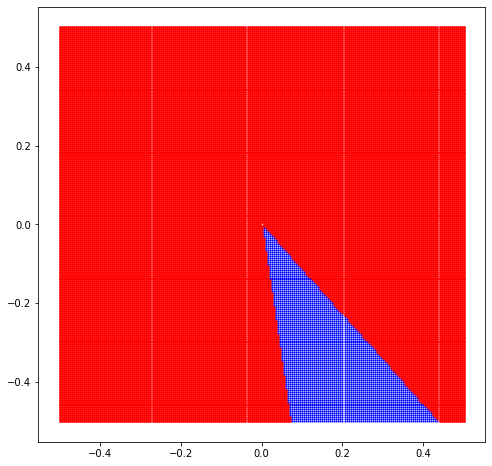

In [17]:
#test
import numpy as np
Grid = 200
k = 0.5
x = np.linspace(-k,k,Grid+1)
y = np.linspace(-k,k,Grid+1) 

xv,yv = np.meshgrid( x , y )
X_test = np.array([xv.flatten(),yv.flatten()])
X_test = X_test.transpose()
#np.random.shuffle(X_test)

Y_test = model.predict(X_test)
Y_test = np.rint(Y_test)

zero_class_test = np.where(Y_test[:, 0])
one_class_test = np.where(Y_test[:, 1])

plt.figure(figsize=(8, 8))
plt.scatter(X_test[zero_class_test, 0], X_test[zero_class_test, 1], marker='o',s=3, facecolors='r', linewidths=1, label='Class 1')
plt.scatter(X_test[one_class_test, 0], X_test[one_class_test, 1], marker='o', s=1, facecolors='b', linewidths=1, label='Class 2')
plt.show()
plt.savefig(directory+'/'+'test')
plt.close()

In [ ]:
import multiprocessing
from multiprocessing import Pool
from functools import partial
import pdb

Grid = 200
k = 0.5
x = np.linspace(-k,k,Grid+1)
y = np.linspace(-k,k,Grid+1) 

xv,yv = np.meshgrid( x , y )
X_test = np.array([xv.flatten(),yv.flatten()])
X_test = X_test.transpose()


#loop for all data points to get activations
i_data = 0
activations = []

for test_data in X_test:
    print("get activation progress:{0}%".format(round((i_data + 1) * 100 / len(X_test))), end="\r")
    activations.append(get_activation(test_data))
    i_data = i_data + 1
print(end="\n")

f = partial(assign_color,activations)

i_color=0
data_activation_color=[]

pool = Pool(4)
for y in pool.map(f, range(len(activations))):
    i_color+=1
    print("get data color progress:{0}%".format(round((i_color + 1) * 100 / len(activations))), end="\r")
    data_activation_color.append(y)
print(end="\n")
# for y in range(len(activations)):
#     i_color+=1
#     print("get data color progress:{0}%".format(round((i_color + 1) * 100 / len(activations))), end="\r")
#     data_activation_color.append(f(y))
# print(end="\n")

data_activation_color = np.asarray(data_activation_color)
act_clusters = np.unique(data_activation_color)
cluster_index = []
for j in range(len(act_clusters)):
    cluster_index.append(np.where(data_activation_color == act_clusters[j]))

pool.close()
pool.join()

get activation progress:100%


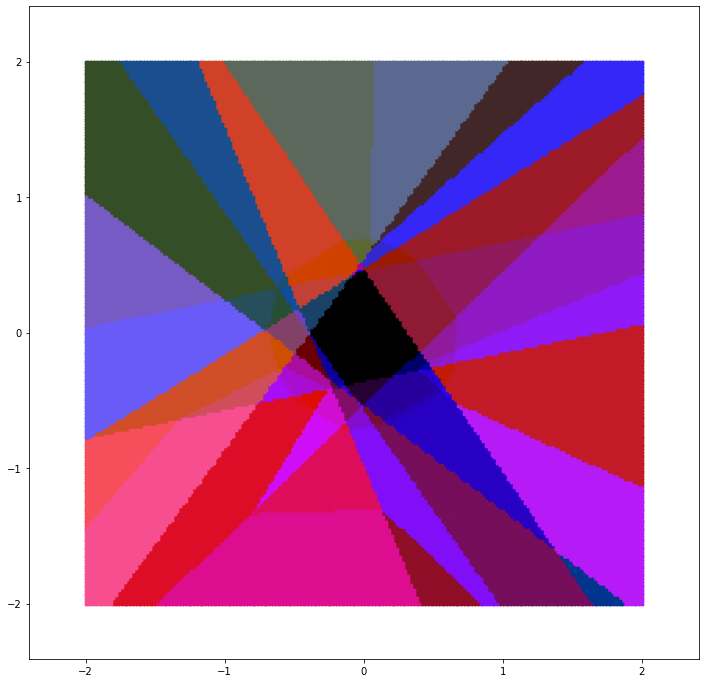

<Figure size 432x288 with 0 Axes>

In [47]:
progress = 0
plt.figure(figsize=(12, 12))
for k in range(len(cluster_index)):
    progress += 1
    #print("Progress:{0}%".format(round((progress + 1) * 100 / len(cluster_index))), end="\r")
    plt.scatter(X_test[cluster_index[k], 0], X_test[cluster_index[k], 1], marker='o',s=4, color=colors[data_activation_color[cluster_index[k]][0]]/255.0, linewidths=2)
plt.margins(x=0.1, y=0.1)
plt.show()
plt.savefig('activation')